In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,8)

import statsmodels.formula.api as smf


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('smokers_prep.csv')
df.head()

,Unnamed: 0,age,bmi,children,charges,charges_BC,smoker_encoded,region_encoded,sex_encoded
0,0,-0.863636,-0.279446,-0.5,16884.9240,-0.952423,0,3,0
1,11,1.090909,-0.456054,-0.5,27808.7251,-0.324313,0,2,0
2,14,-0.500000,1.281503,-0.5,39611.7577,0.231310,0,2,1
3,19,-0.363636,0.532291,-0.5,36837.4670,0.108754,0,3,1
4,23,-0.181818,0.161525,0.0,37701.8768,0.147399,0,0,0


Separamos la variable respuesta de la variable predictiva

In [3]:
X = df.drop('charges', axis =1)
y = df['charges']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

In [4]:
print("Datos de entrenamiento")
print("-----------------------")
print(y_train.describe())

Datos de entrenamiento
-----------------------
count      219.000000
mean     31697.790853
std      11328.606867
min      12829.455100
25%      20759.808425
50%      33900.653000
75%      40812.375275
max      63770.428010
Name: charges, dtype: float64


In [5]:
print("Datos de testeo")
print("-----------------------")
print(y_test.describe())

Datos de testeo
-----------------------
count       55.000000
mean     33453.587730
std      12362.231018
min      14571.890800
25%      21089.955800
50%      36021.011200
75%      42167.826750
max      62592.873090
Name: charges, dtype: float64


Al no tener el modelo normalizado no podemos hacer una regresión lineal así que haremos un decission tree

In [6]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [7]:
regressor.max_depth
regressor.max_features

In [8]:
X.head()

,Unnamed: 0,age,bmi,children,charges_BC,smoker_encoded,region_encoded,sex_encoded
0,0,-0.863636,-0.279446,-0.5,-0.952423,0,3,0
1,11,1.090909,-0.456054,-0.5,-0.324313,0,2,0
2,14,-0.500000,1.281503,-0.5,0.231310,0,2,1
3,19,-0.363636,0.532291,-0.5,0.108754,0,3,1
4,23,-0.181818,0.161525,0.0,0.147399,0,0,0


In [9]:
# max features

max_features = np.sqrt(len(X_train.columns))
max_features

2.8284271247461903

In [10]:
regressor.tree_.max_depth # la mitad de la profundidad va a ser el límite

11

In [11]:
# max depth

print(regressor.tree_.max_depth)

11


In [12]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [13]:
# sacamos las métricas para ver si hay overfitting

def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,394.018613,512893.755529,716.166011,0.996582,test,Decission Tree I
1,0.000000,0.000000,0.000000,1.000000,train,Decission Tree I


In [14]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [4, 5, 6, 7], #[10, 12, 14]
        "min_samples_split": [10, 50, 100], # [100, 150, 200] -> número de datos
        "max_features": [1,2,3,4,5,6], # [4, 6]
        "min_samples_leaf": [100, 150, 200]
        } 

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=3, # muestra el progreso - 2 pa que no te saque todo el input
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [15]:
# ajustamos el modelo de nuevo

%time
gs.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [100, 150, 200],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [16]:
# sacamos cual es el mejor de todos los que hemos testeado usando el método best_estimator_

best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=4, max_features=1, min_samples_leaf=100,
                      min_samples_split=10)

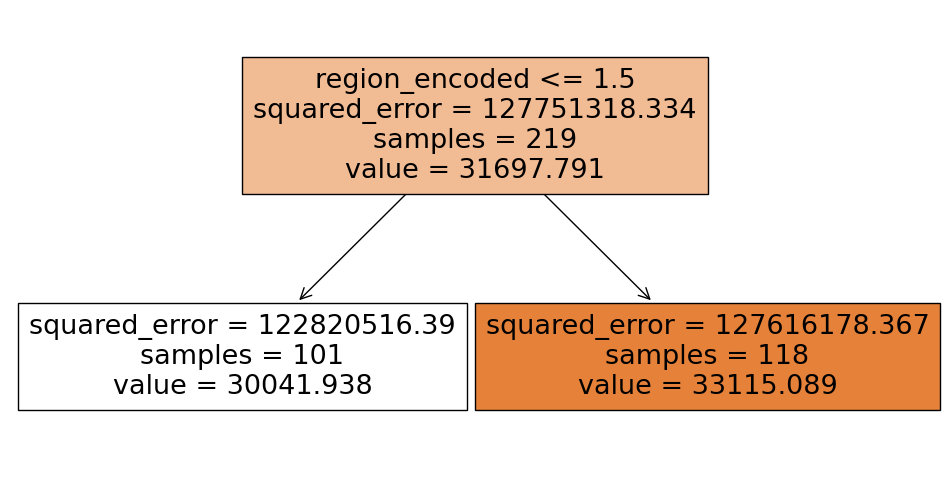

In [17]:
# volvamos a intentar visualizar el árbol a ver como se ve: 

fig = plt.figure(figsize=(12, 6))
tree.plot_tree(best_tree, feature_names=X_train.columns, filled=True);